In [1]:
import sys
import os 
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

from learning.collections_env.collections_env import CollectionsEnv, MAX_ACCOUNT_BALANCE
from learning.utils.wrappers import DiscretizedActionWrapper, StateNormalization
from learning.policies.dqn import DQNAgent, DefaultConfig
from learning.utils import misc
from learning.policies.discrete_optimal_policy import DiscretePolicyConstructor
from dcc import Parameters, AAV, OAV

from tqdm import tqdm
from joblib import delayed, Parallel

import logging
import numpy as np
import pickle
import copy
from itertools import product
#import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K


from IPython.display import HTML, clear_output

import matplotlib.pyplot as plt
# import seaborn as sns

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from learning.utils.load_experiment import LoadExperiment
from learning.policy_pricer import policy_pricer, cython_pricer_optimized

List regularized models:

In [2]:
ldr = LoadExperiment(backup=False)
os.listdir(os.path.join(ldr.repo, 'models'))

['DQN200TRUEp-0',
 'DQN200TRUEp-1',
 'DQN200TRUEp-2',
 'DQN200TRUEp-3',
 'DQN200TRUEp-4',
 'L1_high-0',
 'L1_high-1',
 'L1_high-2',
 'L1_high-3',
 'L1_high-4',
 'L1_low-0',
 'L1_low-1',
 'L1_low-2',
 'L1_low-3',
 'L1_low-4',
 'L2_high-0',
 'L2_high-1',
 'L2_high-2',
 'L2_high-3',
 'L2_high-4',
 'L2_low-0',
 'L2_low-1',
 'L2_low-2',
 'L2_low-3',
 'L2_low-4']

Test loading of an agent:

In [11]:
cps = ldr.list_checkpoints('DQN200Truep-0', -1)
ag = ldr.load_agent_from_path(cps[5])
ag.main_net.summary()

[WARNING] [2021-04-07 16:08:57,191] [tensorflow] - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                30        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 33        
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________


Let's setup an evaluation portfolio, i.e., starting positions

In [12]:
SEED = 1
np.random.seed(SEED)

n_acc = 100
llb = 0.2
lub = 1.2
wlb = 50.
wub = 200.

portfolio = np.array([[np.random.uniform(llb, lub), np.random.uniform(wlb, wub)] for _ in range(n_acc)])

Text(0.5, 1.0, 'portfolio')

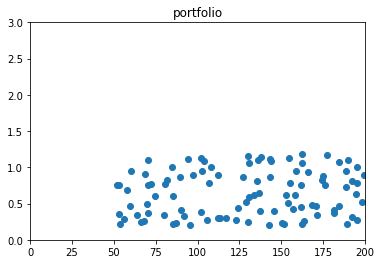

In [13]:
fig, ax = plt.subplots()
ax.scatter(portfolio[:, 1], portfolio[:, 0])
ax.set_ylim([0, 3])
ax.set_xlim([0, 200])
ax.set_title('portfolio')

In [14]:
def aav_portfolio(portf):
    aav = AAV(ag.env.params)
    values = np.zeros(len(portf))
    for i, value in enumerate(portf):
        values[i] = aav.u(value[0], value[1])
    return -np.mean(values)
        
def compute_v(portf):
    # probably taking max of a portfolio would be better here
    oav = OAV(ag.env.params, 200)
    oav.solve_v()
    values = np.zeros(len(portf))
    for i, value in enumerate(portf):
        values[i] = oav.v(value[0], value[1])
    return -np.mean(values)

AAV_VAL = aav_portfolio(portfolio)
VOPT_VAL = compute_v(portfolio)

[INFO] [2021-04-07 16:09:23,616] [AAV] - Instantiated @ AAV
[INFO] [2021-04-07 16:09:23,639] [AAV] - Instantiated @ AAV
[INFO] [2021-04-07 16:09:23,652] [OAV] - Launching the value function procedure.
[INFO] [2021-04-07 16:09:23,653] [OAV] - Computing the value function on (0.00, 21.10].
[INFO] [2021-04-07 16:09:23,660] [OAV] - Computing the value function on (21.10, 23.45].
[INFO] [2021-04-07 16:09:24,915] [OAV] - Computing the value function on (23.45, 26.05].
[INFO] [2021-04-07 16:09:26,044] [OAV] - Computing the value function on (26.05, 28.95].
[INFO] [2021-04-07 16:09:27,822] [OAV] - Computing the value function on (28.95, 32.16].
[INFO] [2021-04-07 16:09:28,616] [OAV] - Computing the value function on (32.16, 35.73].
[INFO] [2021-04-07 16:09:29,731] [OAV] - Computing the value function on (35.73, 39.71].
[INFO] [2021-04-07 16:09:31,926] [OAV] - Computing the value function on (39.71, 44.12].
[INFO] [2021-04-07 16:09:33,549] [OAV] - Computing the value function on (44.12, 49.02].

Now lets calculate account values. Under the hood, this runs cython.

In [17]:
logging.getLogger().setLevel(logging.ERROR)

def calc_checkpoint_value(accs, checkpoint, niter= 5000, w_points = 100, l_points=100, lam_lim=5):
    res = np.zeros(len(accs), dtype='float64')
    agent = ldr.load_agent_from_path(checkpoint);
    sys.stdout.flush()
    ww, ll, p, z = policy_pricer.create_map(agent, w_points = w_points, l_points=l_points, lam_lim=lam_lim, larger_offset=True)
    for i, acc in enumerate(accs):
        vals = np.asarray(cython_pricer_optimized.value_account(acc, ww, ll, p, cython_pricer_optimized.convert_params_obj(agent.env.params), agent.env.env.action_bins, n_iterations=niter))
        res[i] = np.mean(vals)
    return np.mean(res), np.std(res)

def calc_agent(ldr, name, accs, log_num=0, niter= 5000, w_points = 100, l_points=100, lam_lim=5):
    checkpoint_paths = ldr.list_checkpoints(name, log_num=log_num)
    vals = np.zeros(len(checkpoint_paths))
    stds = np.zeros(len(checkpoint_paths))
    for i, path in enumerate(tqdm(checkpoint_paths)):
        vals[i], stds[i] = calc_checkpoint_value(accs, path, niter=niter, w_points = w_points, l_points=l_points, lam_lim=lam_lim)
    return vals, stds


def calc_agent_parallel(ldr, name, accs, log_num=0, niter= 5000, w_points = 100, l_points=100, lam_lim=5, n_jobs=20):
    checkpoint_paths = ldr.list_checkpoints(name, log_num=log_num)
#     vals = np.zeros(len(checkpoint_paths))
#     stds = np.zeros(len(checkpoint_paths))
    rets = Parallel(n_jobs=n_jobs)(delayed(calc_checkpoint_value)(accs, path, niter=niter, w_points = w_points, l_points=l_points, lam_lim=lam_lim) for path in checkpoint_paths)
    return rets

def value_names(ldr, names, accs, n_jobs=20, log_num=0, niter= 5000, w_points = 100, l_points=100, lam_lim=5):
    if os.path.isdir('results_regularizer'):
        print('Looks like there are some results already computed. Loading instead.')
        return load_obj('MC_5000_evaluated')
    else:
        print('Recomputing for a given portfolio:')
        os.makedirs('results_regularizer', exist_ok=True)
    results = {}
    for i, name in enumerate(tqdm(names)):
        if n_jobs>1:
            results[name] = (calc_agent_parallel(ldr, name, accs, log_num=log_num, niter= niter, w_points = w_points, l_points=l_points, lam_lim=lam_lim, n_jobs=n_jobs))
        else:
            results[name] = (calc_agent(ldr, name, accs, log_num=log_num, niter=niter, w_points = w_points, l_points=l_points, lam_lim=lam_lim, n_jobs=n_jobs))
        save_obj(results, 'MC_5000_evaluated')
    return results
            
def save_obj(obj, name ):
    with open('results_regularizer/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('results_regularizer/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [20]:
AGENTS = os.listdir(os.path.join(ldr.repo, 'models'))
# "['DQN200TRUEp-0', 'DQN200TRUEp-1', 'DQN200TRUEp-2', 'DQN200TRUEp-3', 'DQN200TRUEp-4', 'L1_high-0', 'L1_high-1', 'L1_high-2', 'L1_high-3', 'L1_high-4', 'L1_low-0', 'L1_low-1', 'L1_low-2', 'L1_low-3', 'L1_low-4', 'L2_high-0', 'L2_high-1', 'L2_high-2', 'L2_high-3', 'L2_high-4', 'L2_low-0', 'L2_low-1', 'L2_low-2', 'L2_low-3', 'L2_low-4']"

In [22]:
vals = value_names(ldr, AGENTS, portfolio, n_jobs=45, log_num=0, niter= 5000, w_points = 100, l_points=100, lam_lim=5)

Looks like there are some results already computed. Loading instead.


In [38]:
LEARNING_STEPS = 50000
STEP_BY = 500
LEARNING_STEPS_CUTOFF = 49000

def process_plot_data(vals, key: str, cutoff: int):
    data_from_key = dqns = [ l for k,l in vals.items() if k.startswith(key)]
    avgs = np.zeros((cutoff, len(data_from_key)), dtype='float64')
    stds = np.zeros((cutoff, len(data_from_key)), dtype='float64')
    for i, teration in enumerate(data_from_key):
        avgs[:, i] = [data[0] for data in data_from_key[i][:cutoff]]
        stds[:, i] = [data[1] for data in data_from_key[i][:cutoff]]
    return avgs, stds

def plot_learning(names, vals, percentage=True, title=None):
    fig, ax = plt.subplots(figsize=(20, 10))
    x = np.arange(0, LEARNING_STEPS_CUTOFF, STEP_BY)
    cutoff = LEARNING_STEPS_CUTOFF // STEP_BY
    a_s = AAV_VAL
    v_s = VOPT_VAL
    ds = []
    if percentage:
        mean_pfolio = np.mean(portfolio, axis=0)[1]
    for i, name in enumerate(names):
        avgs, stds = process_plot_data(vals, name, cutoff)
        if percentage:
            avgs = avgs/mean_pfolio * 100
            a_s = a_s / mean_pfolio * 100
            v_s = VOPT_VAL / mean_pfolio * 100
        stds = np.std(avgs, axis=1)
        avgs = np.mean(avgs, axis=1)
        ax.plot(x, avgs)
        ax.fill_between(x, avgs-stds, avgs+stds, alpha=0.2)
    ax.legend(names)
    ax.set_xlabel(['Learning steps'])
    ax.axhline(a_s, color='red', linestyle='--')
    ax.axhline(v_s, color='brown', linestyle='--')
    if percentage:
        ax.axhline(100, color='black', linestyle=':')
    if title is not None:
        ax.set_title(title)
    

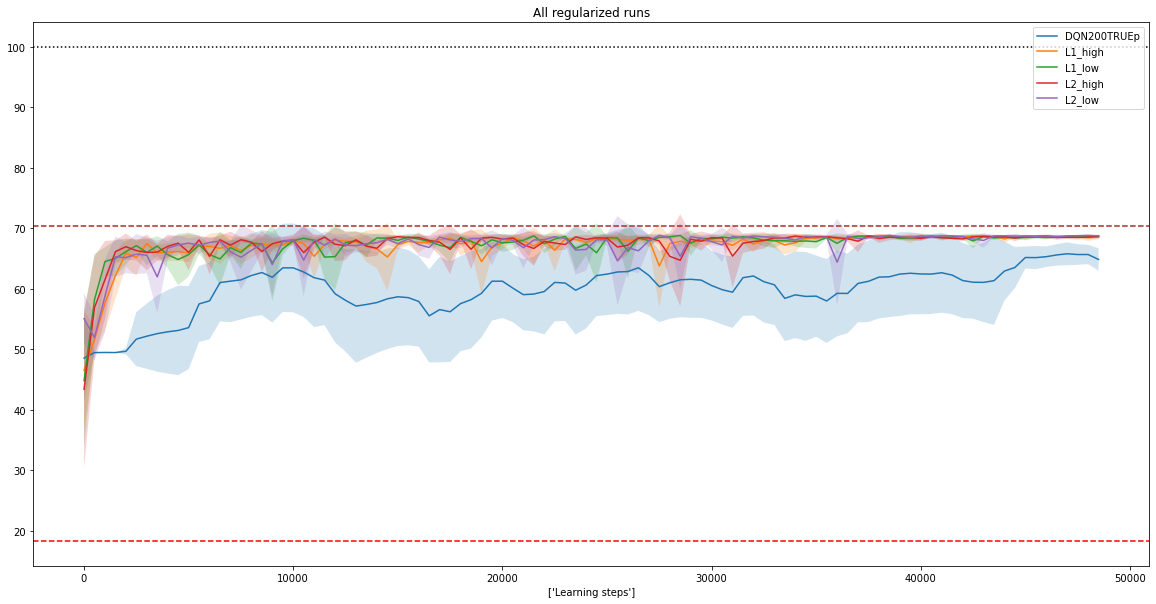

In [39]:
names_reuglarized = ['DQN200TRUEp','L1_high', 'L1_low', 'L2_high', 'L2_low']
plot_learning(names_reuglarized, vals, LEARNING_STEPS_CUTOFF, title='All regularized runs')

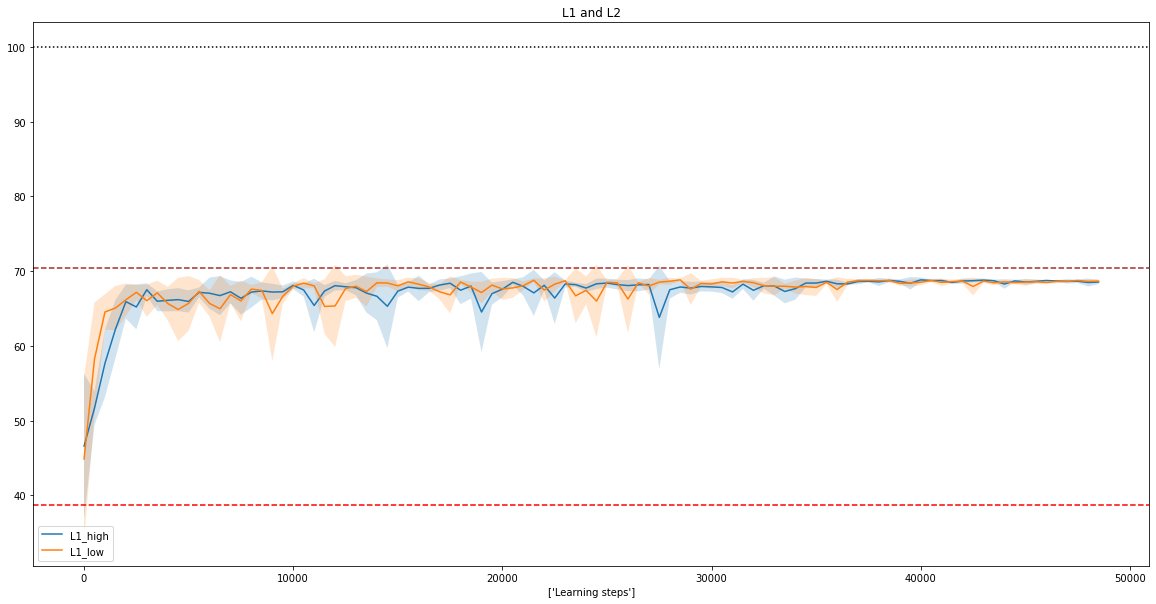

In [40]:
names_reuglarized = ['L1_high', 'L1_low']
plot_learning(names_reuglarized, vals, LEARNING_STEPS_CUTOFF, title='L1 and L2')

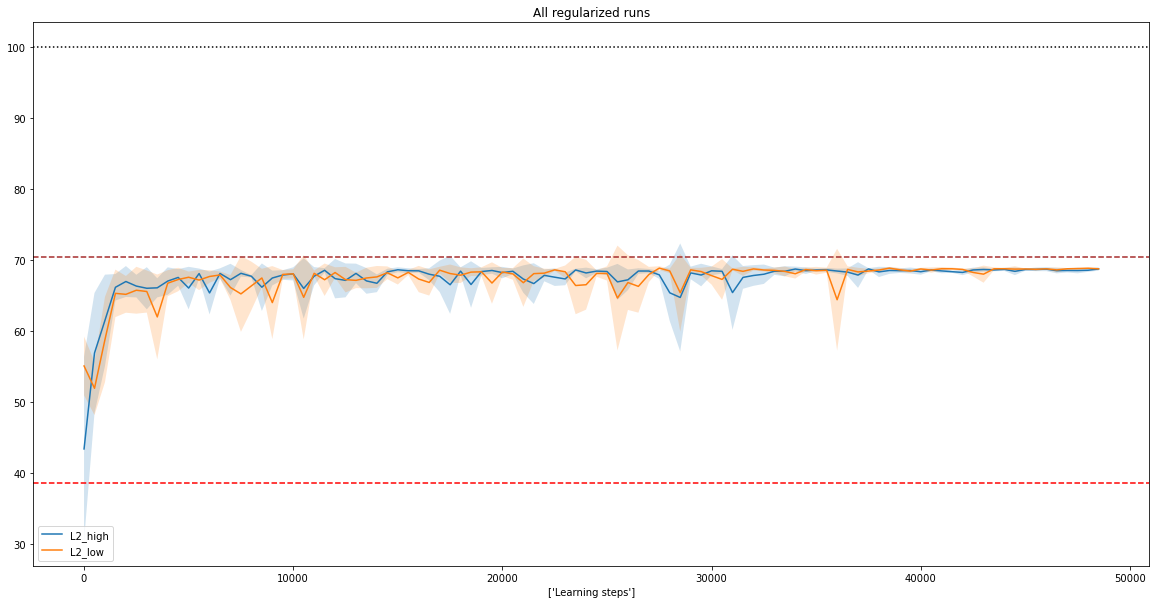

In [41]:
names_reuglarized = ['L2_high', 'L2_low']
plot_learning(names_reuglarized, vals, LEARNING_STEPS_CUTOFF, title='All regularized runs')

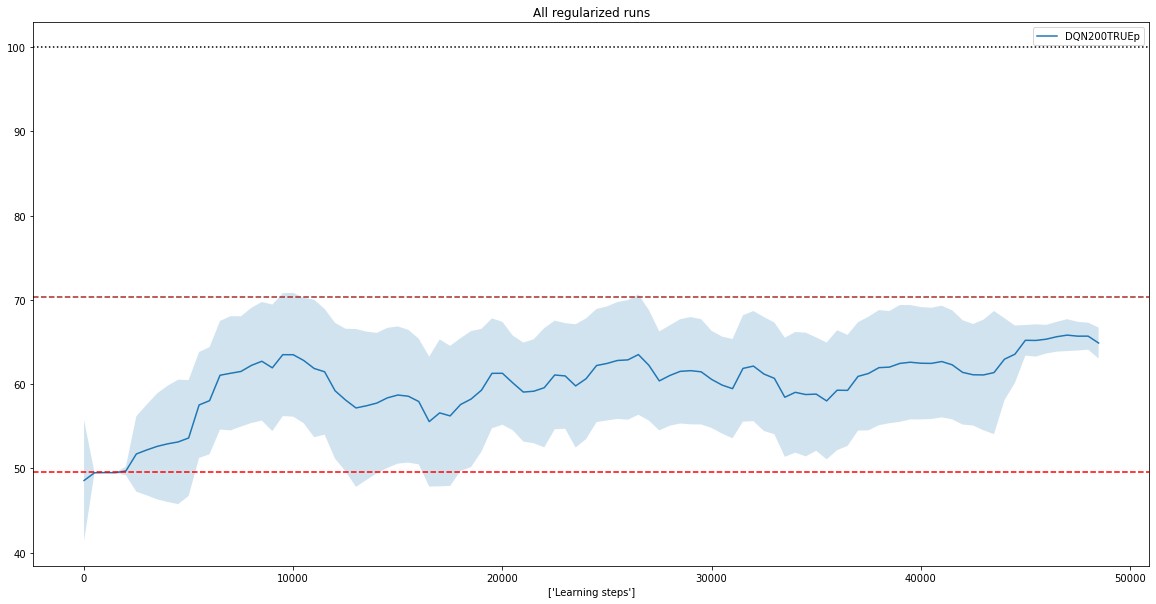

In [47]:
names_reuglarized = ['DQN200TRUEp']
plot_learning(names_reuglarized, vals, LEARNING_STEPS_CUTOFF, title='All regularized runs')

In [42]:
dqns = [ l for k,l in vals.items() if k.startswith('DQN200TRUEp')]
dqnl1_h = [ l for k,l in vals.items() if k.startswith('L1_high')]
dqnl1_l = [ l for k,l in vals.items() if k.startswith('L1_low')]
dqnl2_h = [ l for k,l in vals.items() if k.startswith('L2_high')]
dqnl2_l = [ l for k,l in vals.items() if k.startswith('L2_low')]

In [48]:
np.std([run[1][0] for run in dqns])

0.04127226737701819